In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math

### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
from benchmark_pipeline import calc_ccc, accuracy_plot, error_spatial_plot, sorted_plot

In [4]:
# set input output
prop = 'ph_h2o'
filt = 5
space = 'normal'

if space=='log1p':
    df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    tgt = f'{prop}_log1p'
else:
    tgt = prop
    
output_folder = f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}'
cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
train = pd.read_csv(f'{output_folder}/benchmark_train.pnts_{prop}.csv',low_memory=False)
test = pd.read_csv(f'{output_folder}/benchmark_test.pnts_{prop}.csv',low_memory=False)

In [ ]:
### feature selection
ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)
covs_a = pd.read_csv(f'{folder}/material/001_covar_all.txt').values.tolist()
covs_all = [item for sublist in covs_a for item in sublist]
cal = cal.dropna(subset=covs_all,how='any')

result_rankcv = run_rankcv(cal, covs_all, tgt, spatial_cv_column='tile_id')
feature_list = result_rankcv.groupby(['feature']).count().rename(columns=dict(importance='freq')).reset_index()
features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
# features_freq['accum'] = features_freq['feature'].cumsum()
# knee_index = find_knee(features_freq)
# knee_freq = features_freq.loc[knee_index]['freq']
minf = features_freq.loc[features_freq['feature']==features_freq['feature'].min(),'freq'].values[0]
covs = feature_list[feature_list['freq']>=minf]['feature'].tolist() # choose only those with high frequency
print(f'--------------{len(covs)} features selected for {prop}---------')
# save for records
with open(f'{output_folder}/benchmark_selected.covs_{prop}.txt', 'w') as file:
    for item in covs:
        file.write(f"{item}\n")
        
models = [] #[rf, ann, lgb, rf_weighted, lgb_weighted] #cubist, cubist_weighted, 
model_names = [] #['rf', 'ann', 'lgb', 'rf_weighted', 'lgb_weighted'] # 'cubist',, 'cubist_weighted'

In [ ]:

covs_a = pd.read_csv(f'{output_folder}/benchmark_selected.covs_{prop}.txt').values.tolist()
covs = [item for sublist in covs_a for item in sublist]

### parameter fine tuning
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)
fitting_score = ccc_scorer
## no weights version
# random forest
param_rf = {
    'n_estimators': [60, 80, 100],
    "criterion": [ 'squared_error', 'absolute_error', 'poisson', 'friedman_mse'],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tune_rf = HalvingGridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_rf,
    scoring=fitting_score,
    n_jobs=90, 
    cv=cv,
    verbose=1,
    random_state = 1992
)


tune_rf.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
warnings.filterwarnings('ignore')
rf = tune_rf.best_estimator_
joblib.dump(rf, f'{output_folder}/model_rf.{prop}_{space}.ccc.joblib')
models.append(rf)
model_names.append('rf')


# simple ANN
warnings.filterwarnings('ignore')
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=5000, early_stopping=True, random_state=28))
])
param_ann = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],  # NN structure
    'mlp__activation': ['tanh', 'relu', 'logistic'],  # commonly used activation functions in NN
    'mlp__solver': ['sgd','adam'],  # optimizer set as sgd
    'mlp__alpha': [0.0001, 0.001, 0.01],  # regularization to prevent overfitting
    'mlp__learning_rate': ['constant', 'adaptive'],  # how aggressive the weights update
    'mlp__learning_rate_init': [0.001, 0.01]  # initial learning rate
    
}

tune_ann = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_ann,
    scoring=fitting_score,
    n_jobs=90,
    cv=cv,
    verbose=1,
    random_state=1993
)
tune_ann.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
ann = tune_ann.best_estimator_
joblib.dump(ann, f'{output_folder}/model_ann.{prop}_{space}.ccc.joblib')
models.append(ann)
model_names.append('ann')

# # lightGBR
import lightgbm as lgb
def clean_feature_names(df):
    df.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(',', '').replace('"', '') for col in df.columns]
    return df
from sklearn.preprocessing import FunctionTransformer
clean_names_transformer = FunctionTransformer(clean_feature_names, validate=False)
pipeline = Pipeline([
    ('clean_names', clean_names_transformer),  # Clean feature names
    ('lgbm', lgb.LGBMRegressor(random_state=35,verbose=-1))         # Replace with any model you intend to use
])
param_lgb = {
    'lgbm__n_estimators': [80, 100, 120],  # Lower initial values for quicker testing
    'lgbm__max_depth': [3, 5, 7],  # Lower maximum depths
    'lgbm__num_leaves': [20, 31, 40],  # Significantly fewer leaves
    'lgbm__learning_rate': [0.01, 0.05, 0.1],  # Fine as is, covers a good range
    'lgbm__min_child_samples': [20, 30, 50],  # Much lower values to accommodate small data sets
    'lgbm__subsample': [0.8, 1.0],  # Reduced range, focusing on higher subsampling
    'lgbm__colsample_bytree': [0.8, 1.0],  # Less variation, focus on higher values
    'lgbm__verbosity': [-1]
}

tune_lgb = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_lgb,
    scoring=fitting_score,
    n_jobs=90,
    cv=cv,
    verbose=1,
    random_state=1994
)

tune_lgb.fit(cal[covs], cal[tgt], groups=cal[spatial_cv_column])
lgbmd = tune_lgb.best_estimator_
joblib.dump(lgbmd, f'{output_folder}/model_lgb.{prop}_{space}.ccc.joblib')
models.append(lgbmd)
model_names.append('lgb')

## weighted version
sample_weights = cal[f'{prop}_qa'].values**2
# random forest
tune_rf.fit(cal[covs], cal[tgt], sample_weight=sample_weights, groups=cal[spatial_cv_column])
rf_weighted = tune_rf.best_estimator_
joblib.dump(rf_weighted, f'{output_folder}/model_rf.{prop}_{space}.ccc.weighted.joblib')
models.append(rf_weighted)
model_names.append('rf_weighted')
# lightGBM
fit_params = {'lgbm__sample_weight': sample_weights}
tune_lgb.fit(cal[covs], cal[tgt], **fit_params, groups=cal[spatial_cv_column])
lgb_weighted = tune_lgb.best_estimator_
joblib.dump(lgb_weighted, f'{output_folder}/model_lgb.{prop}_{space}.ccc.weighted.joblib')
models.append(lgb_weighted)
model_names.append('lgb_weighted')


ph_h2o.rf


/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


ph_h2o.ann


/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


ph_h2o.lgb


/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


ph_h2o.rf_weighted


/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


ph_h2o.lgb_weighted


/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


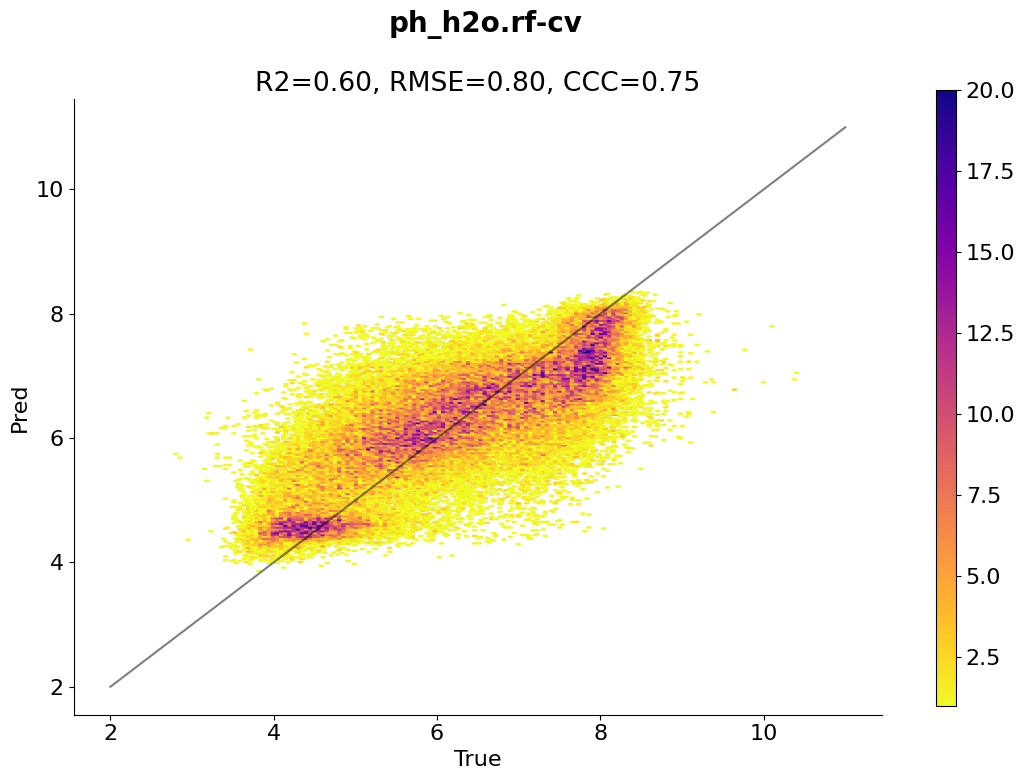

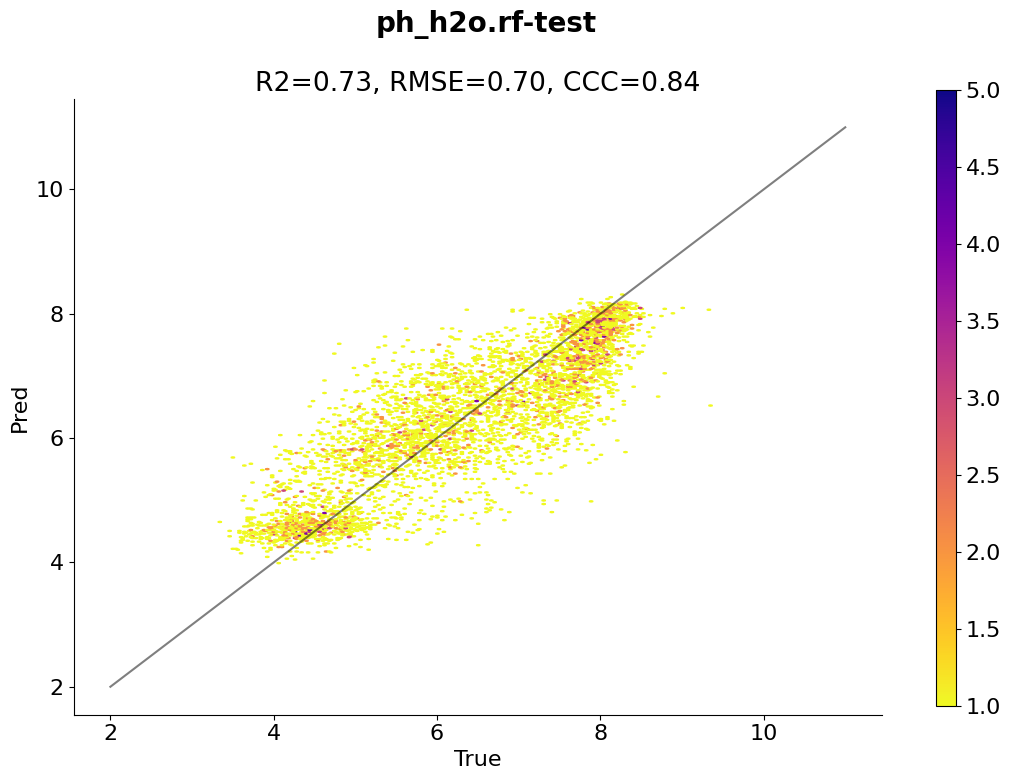

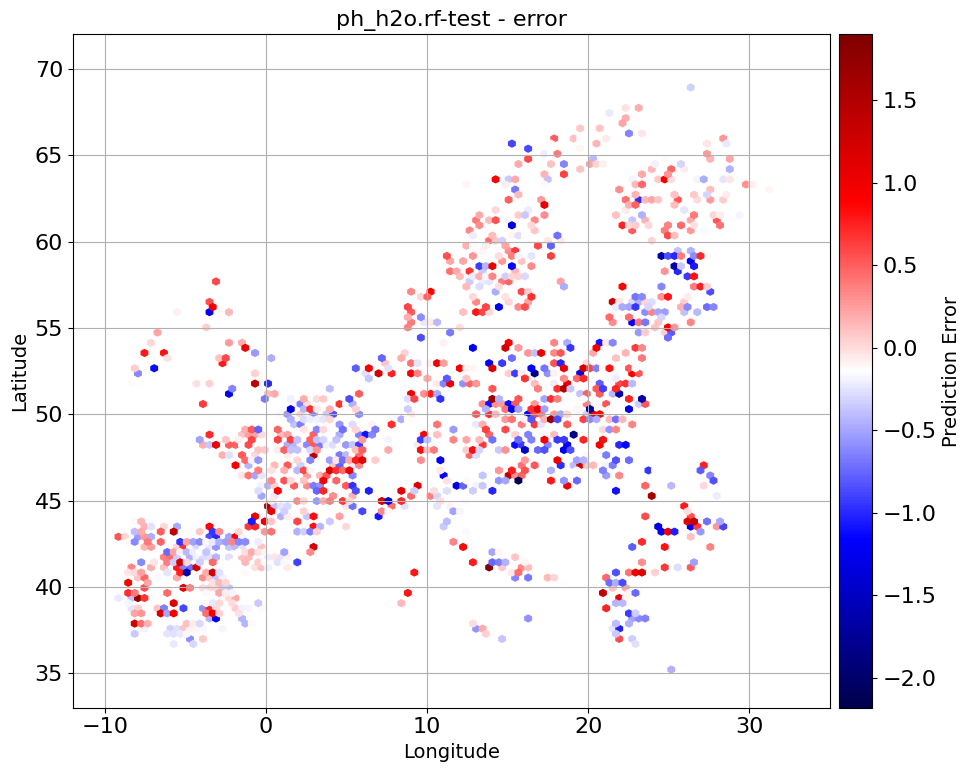

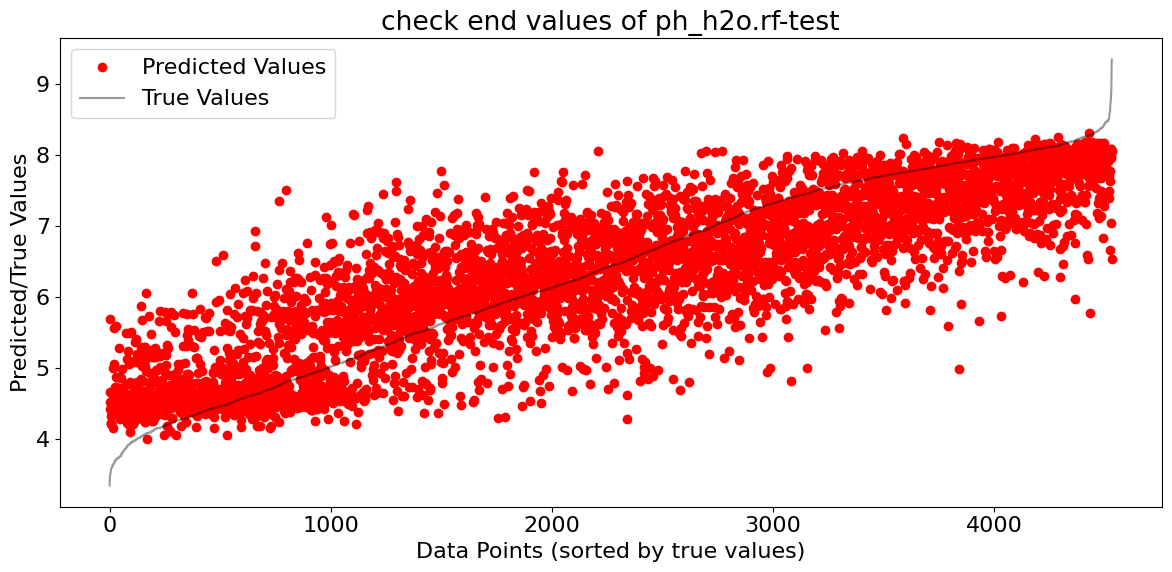

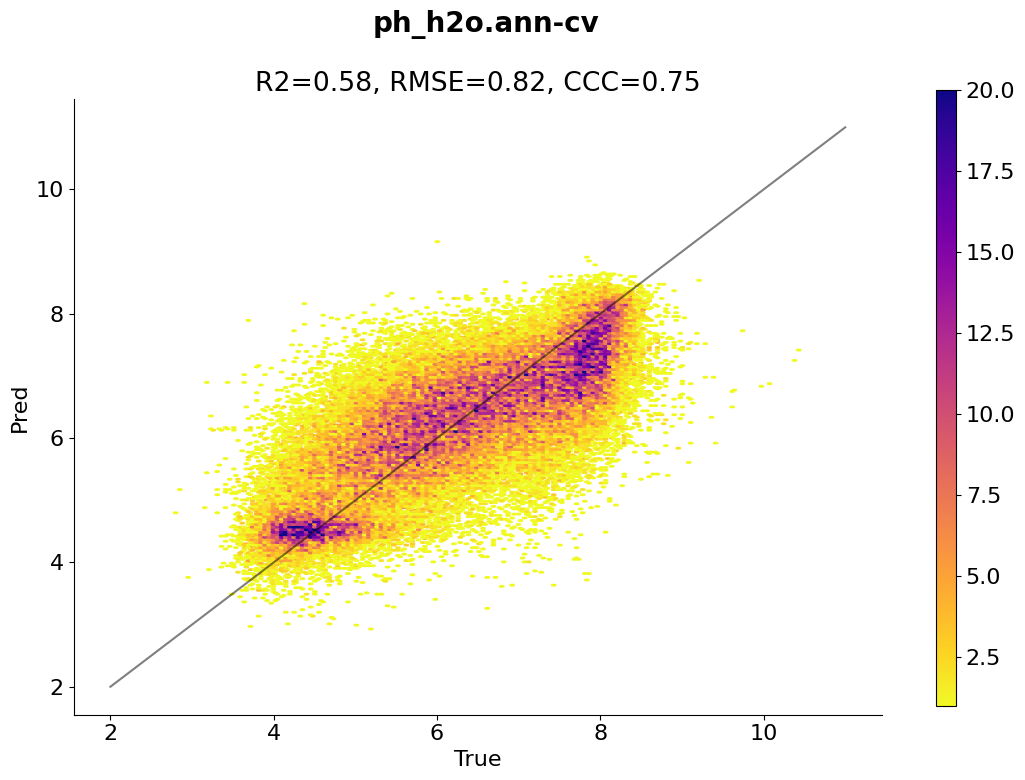

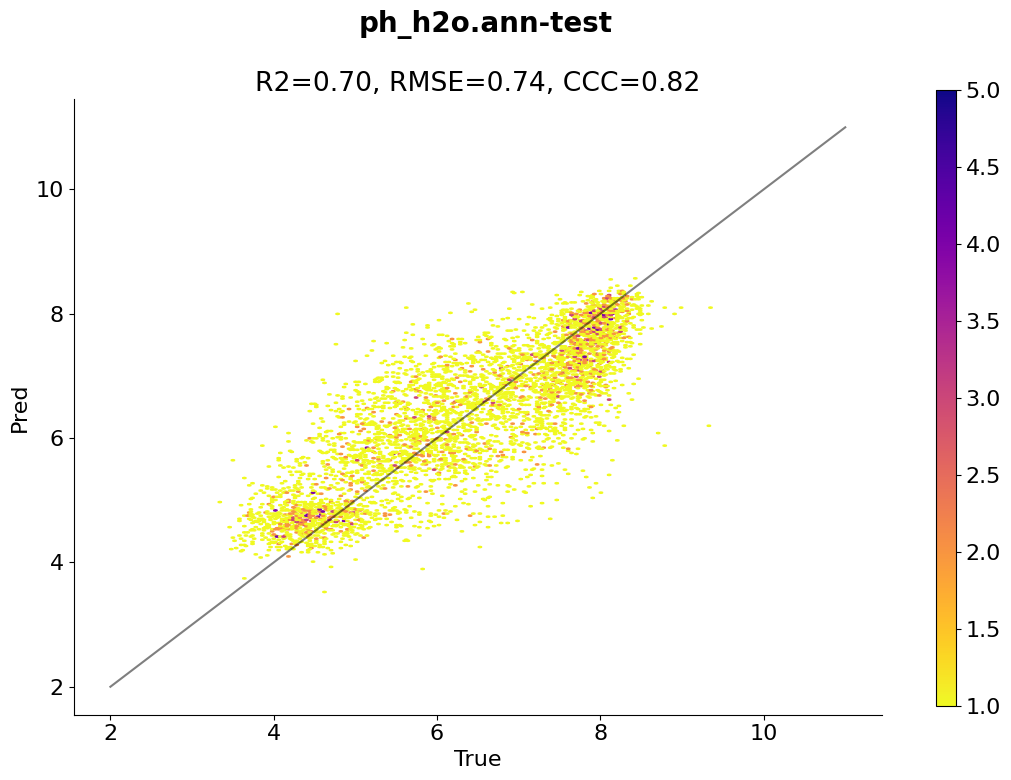

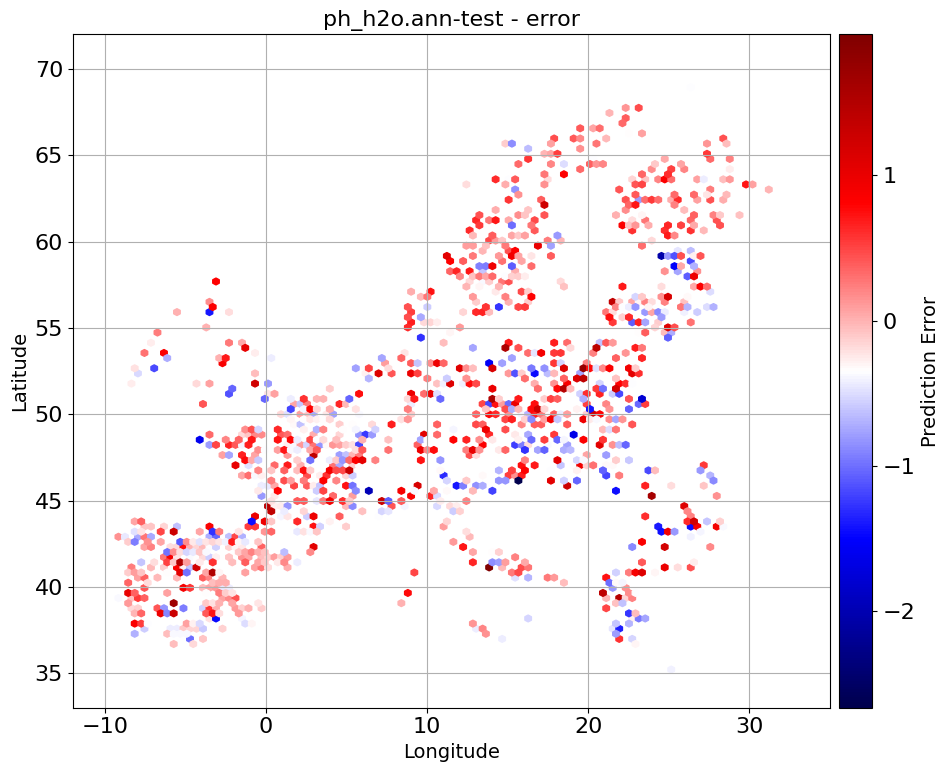

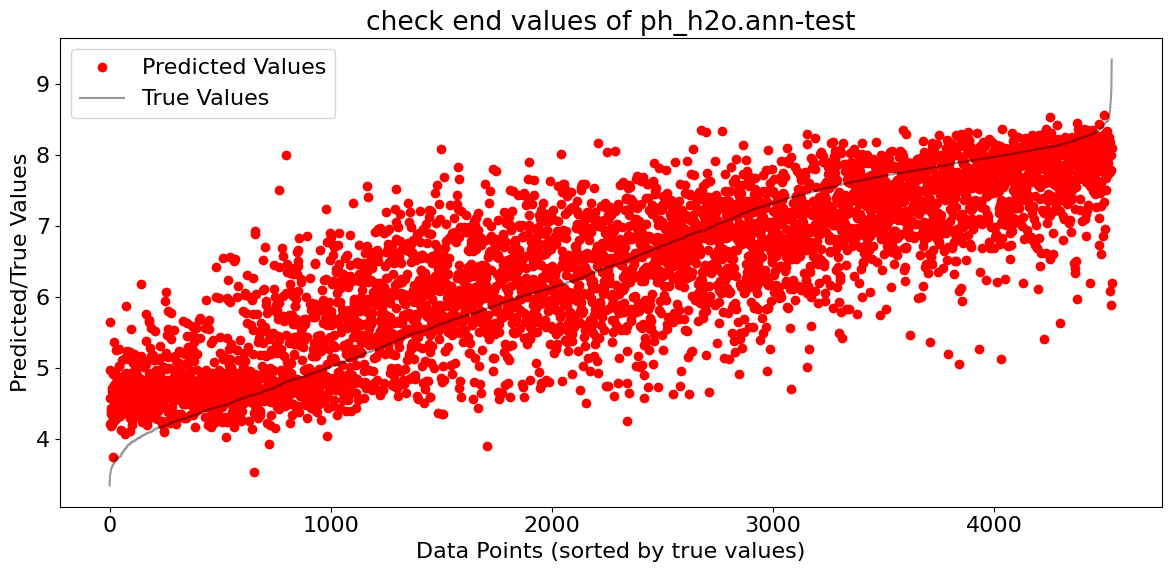

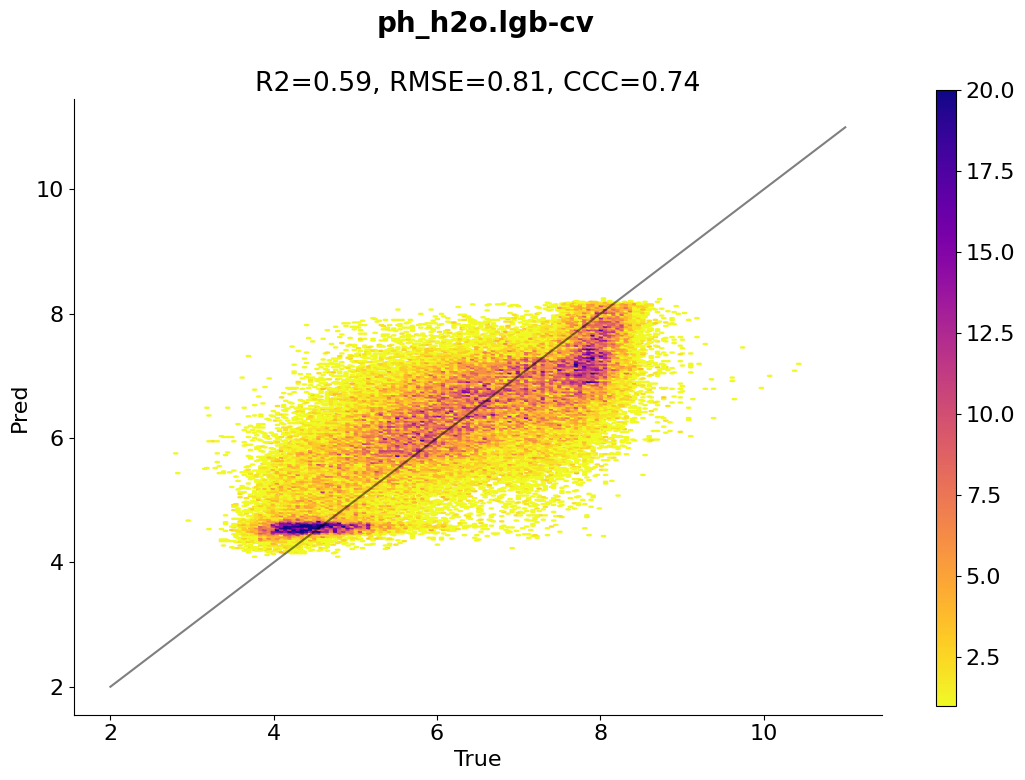

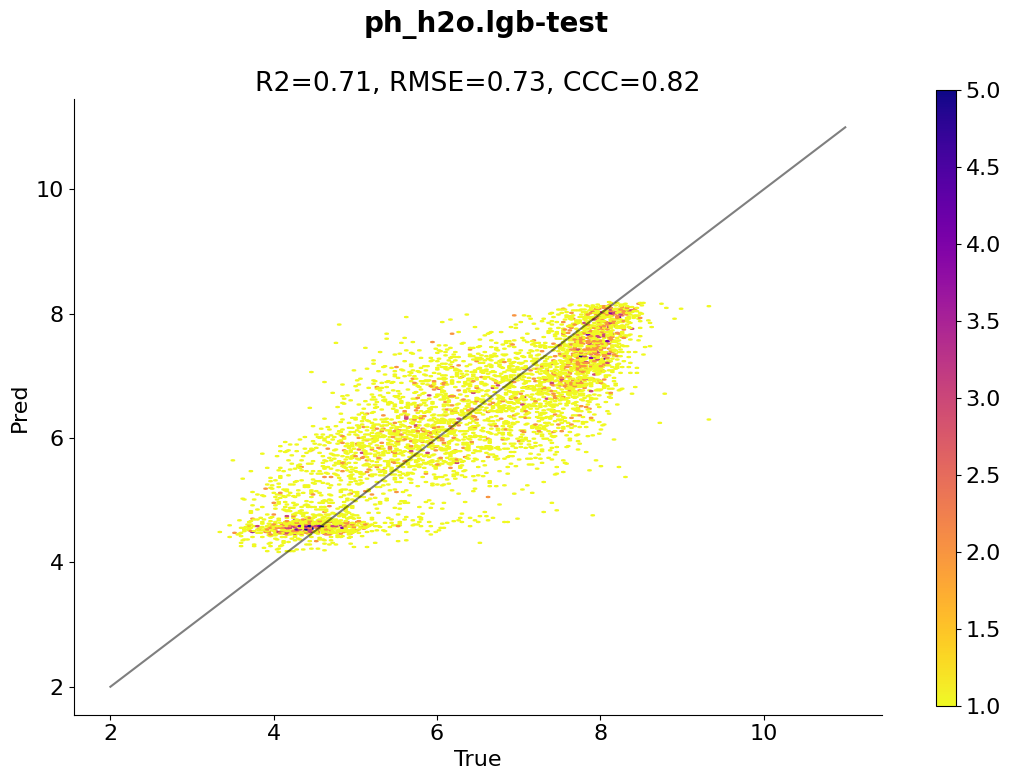

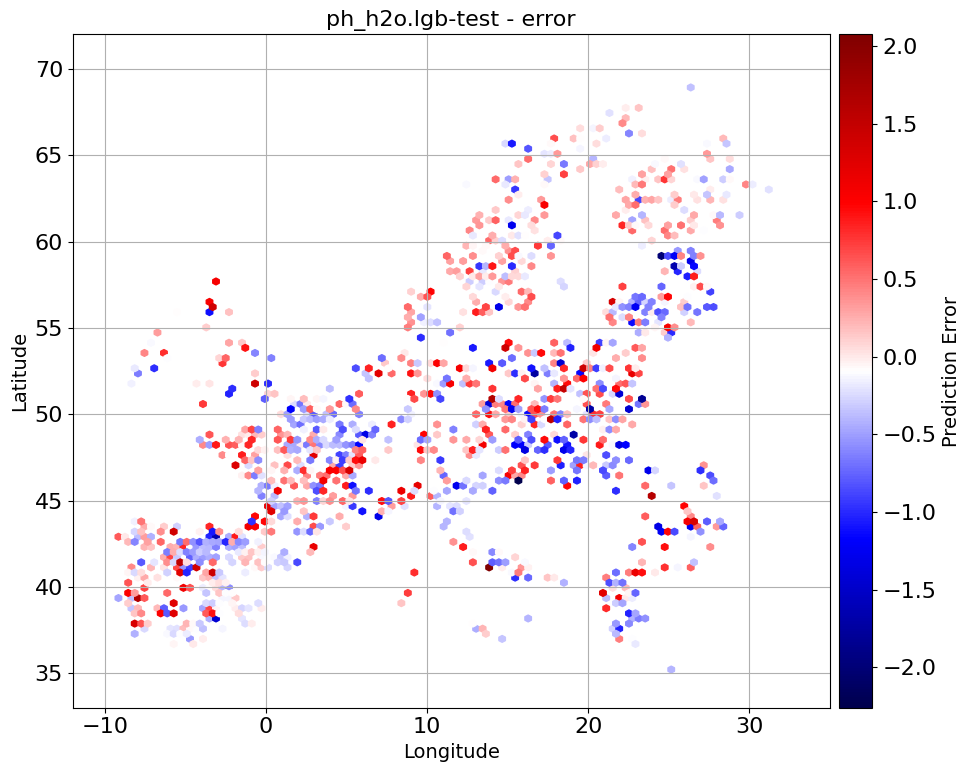

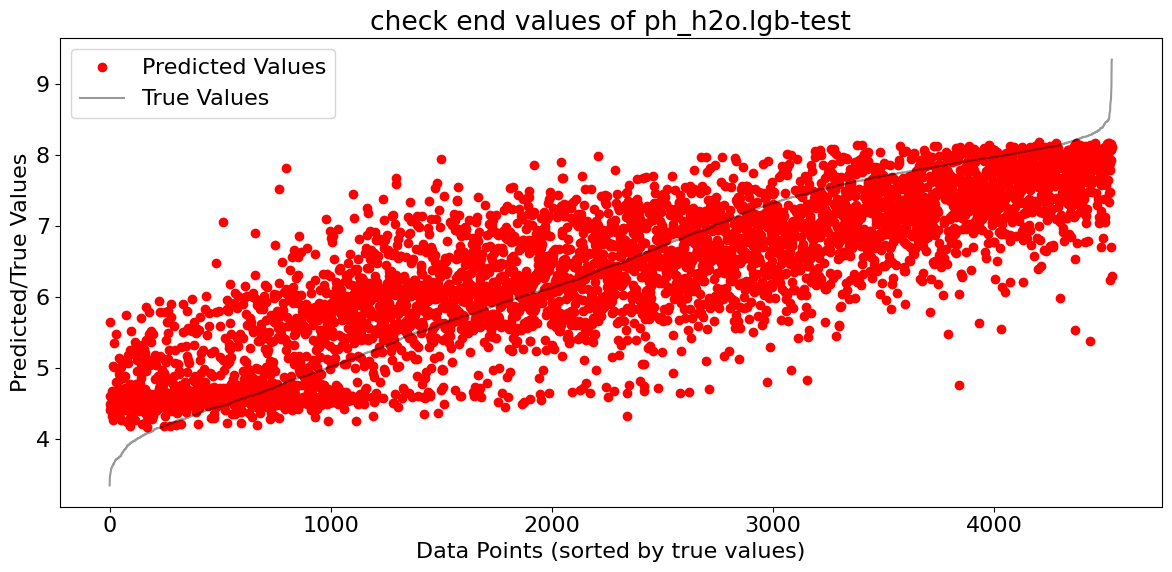

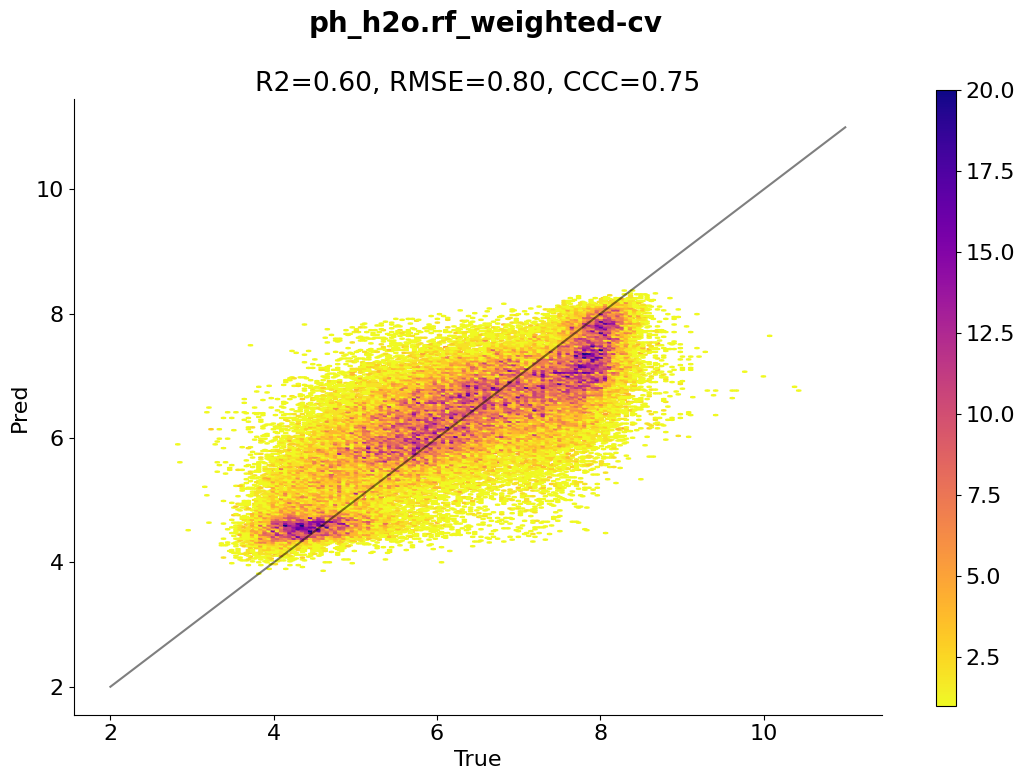

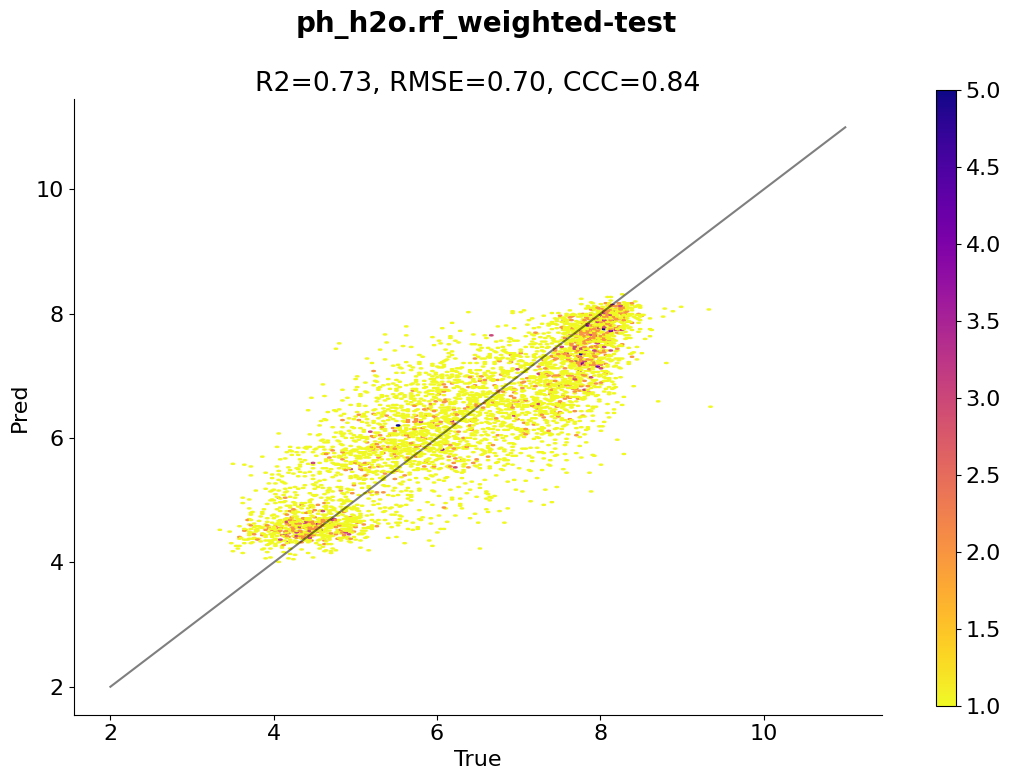

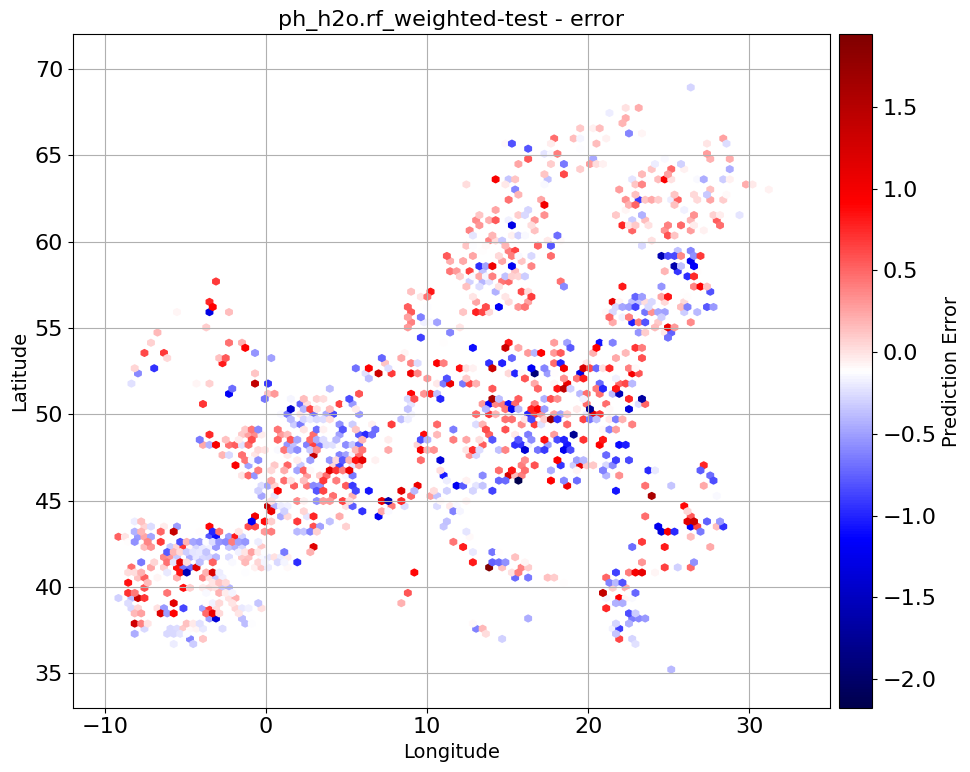

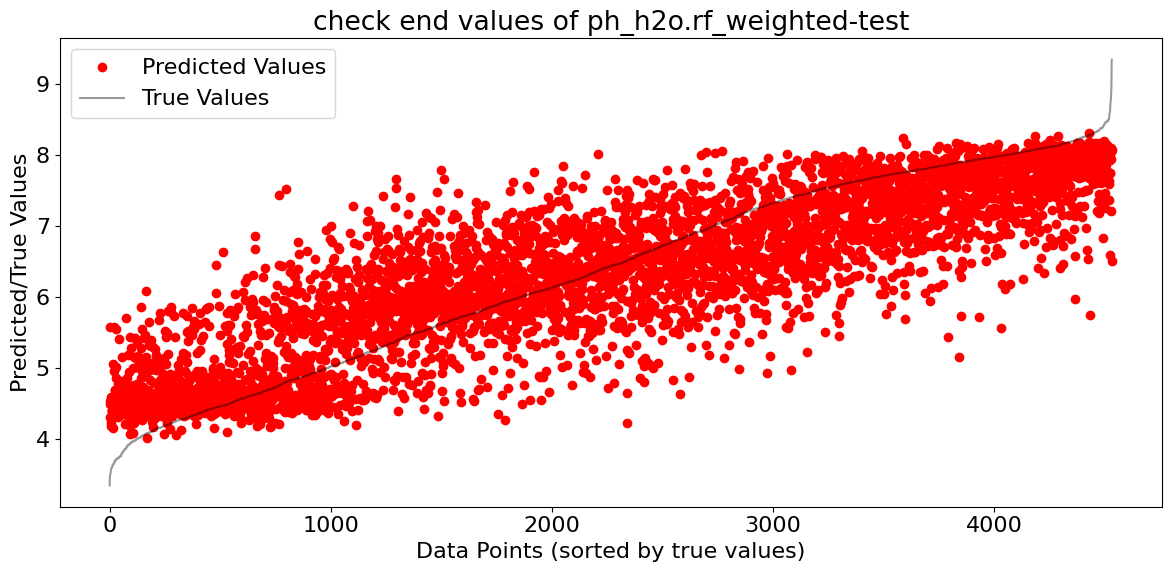

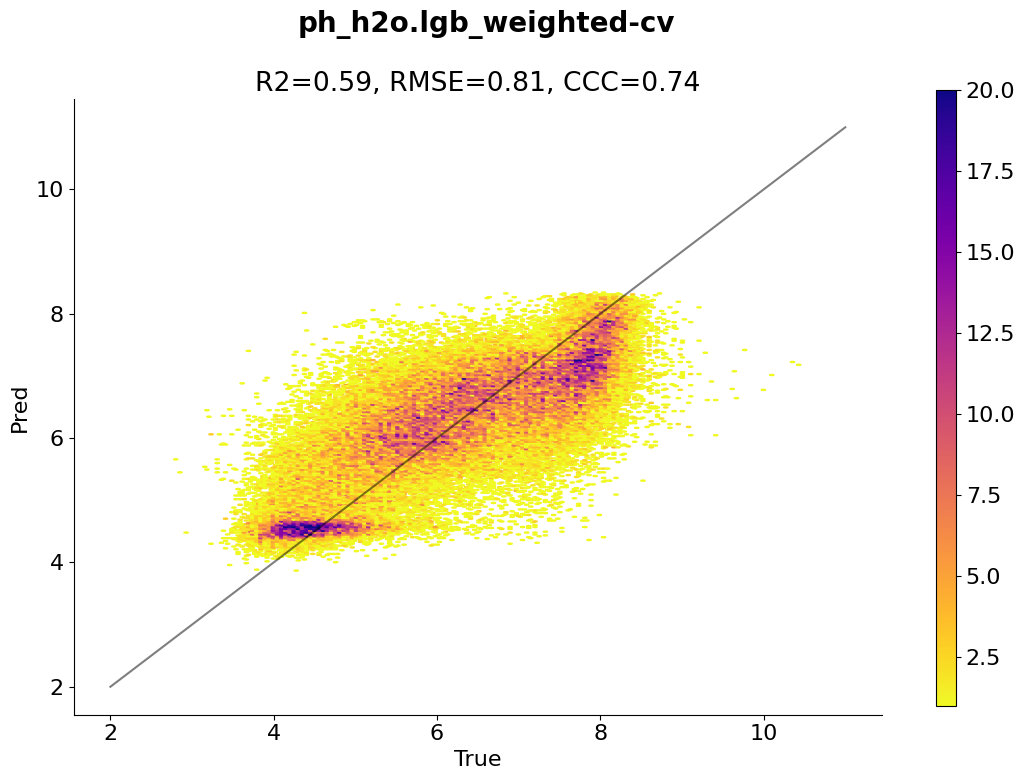

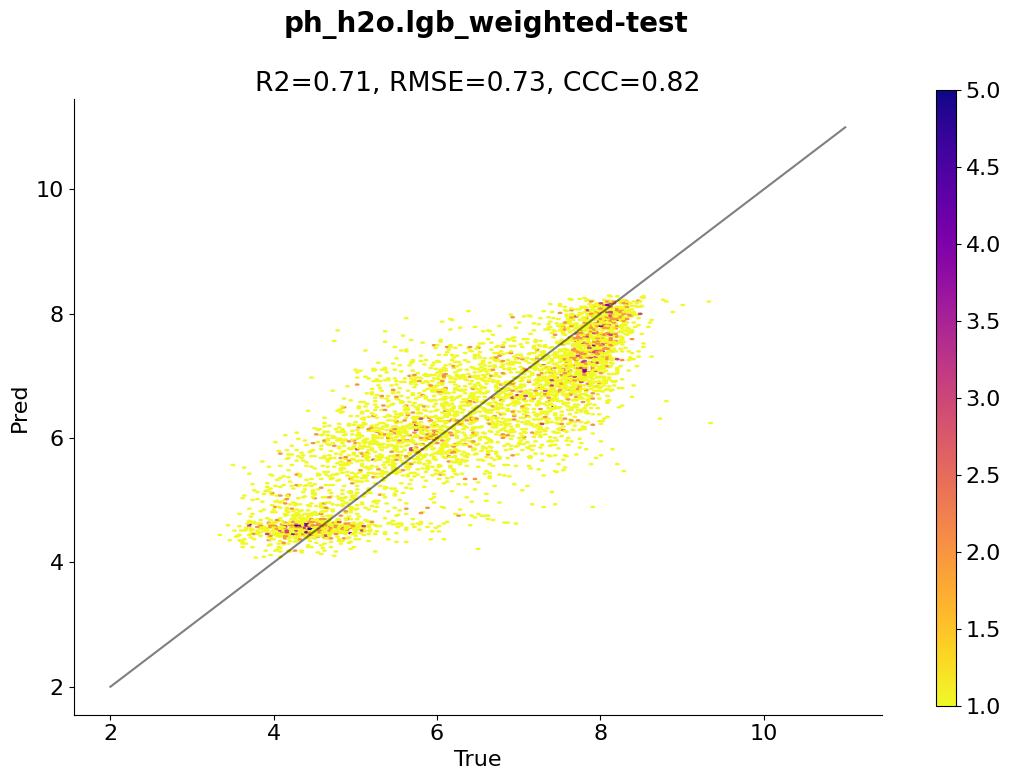

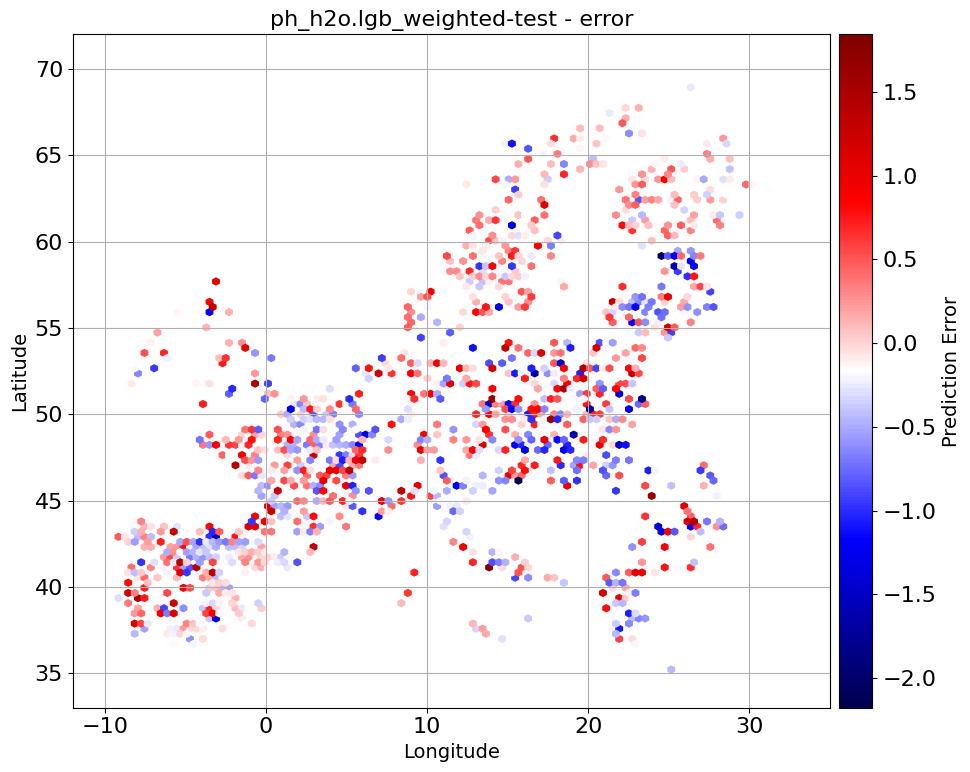

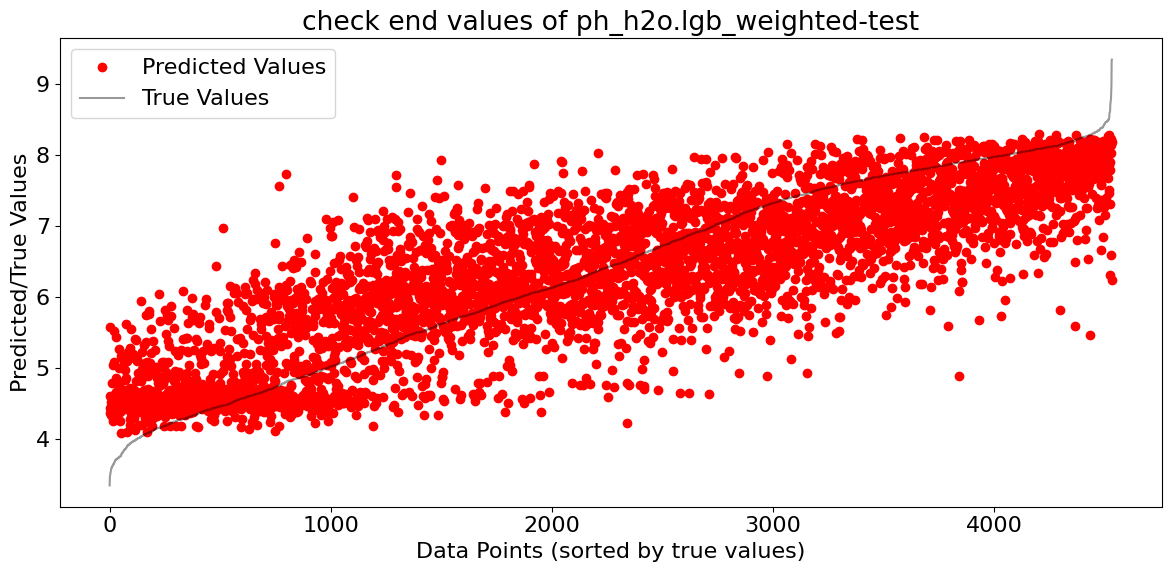

In [5]:

rf = joblib.load(f'{output_folder}/model_rf.{prop}_{space}.ccc.joblib')
ann = joblib.load(f'{output_folder}/model_ann.{prop}_{space}.ccc.joblib')
lgbmd = joblib.load(f'{output_folder}/model_lgb.{prop}_{space}.ccc.joblib')
rf_weighted = joblib.load(f'{output_folder}/model_rf.{prop}_{space}.ccc.weighted.joblib')
lgb_weighted = joblib.load(f'{output_folder}/model_lgb.{prop}_{space}.ccc.weighted.joblib')

model_names = ['rf','ann','lgb','rf_weighted','lgb_weighted']
models = [rf,ann,lgbmd,rf_weighted,lgb_weighted]

covs_a = pd.read_csv(f'{output_folder}/benchmark_selected.covs_{prop}.txt').values.tolist()
covs = [item for sublist in covs_a for item in sublist]

spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)
ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)
fitting_score = ccc_scorer
    
# cv, test
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

sample_weights = train[f'{prop}_qa'].values**2
results = []
show_low = math.floor(train[tgt].min())
show_high = math.ceil(train[tgt].max())

for im in range(len(models)):
    model_name = model_names[im]
    model = models[im]
    figure_name = prop+'.'+model_name
    print(figure_name)
    fit_params = {}
    # Determine the last step name early if it's a pipeline
    if hasattr(model, 'named_steps'):
        last_step_name = list(model.named_steps.keys())[-1]
        if 'weighted' in model_name:
            fit_params = {f'{last_step_name}__sample_weight': sample_weights}
    elif 'weighted' in model_name:
        fit_params = {'sample_weight': sample_weights}
    
    start_time = time.time()
    y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train[spatial_cv_column], n_jobs=90, fit_params=fit_params)
    end_time = time.time()
    cv_time = (end_time - start_time)
    r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, figure_name+ '-cv', output_folder=output_folder, show_range = [show_low, show_high], vmax=20) # visuliazation
    
    start_time = time.time()
    model.fit(train[covs], train[tgt], **fit_params)
    y_pred_val = model.predict(test[covs])
    end_time = time.time()
    testing_time = (end_time - start_time)
    r2_val, rmse_val, ccc_val = accuracy_plot(test[tgt], y_pred_val, figure_name+ '-test', output_folder=output_folder,show_range = [show_low, show_high], vmax=5) # visuliazation
    error_spatial_plot(test[tgt], y_pred_val, test['lat'], test['lon'], figure_name+ '-test', output_folder=output_folder)
    sorted_plot(test[tgt],y_pred_val, figure_name+ '-test', output_folder=output_folder)
    
    # store the metrics
    results.append({
        'title': model_name,
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val,
        'R2_cv': r2_cv,
        'RMSE_cv': rmse_cv,
        'CCC_cv': ccc_cv,
        'cv_time (s)': cv_time,
        'test_time (s)': testing_time
    })
    
    # store feature importance
    if hasattr(model, 'named_steps'):  # Check if it's a pipeline
        last_step = model.named_steps[last_step_name]
        if hasattr(last_step, 'feature_importances_'):
            importances = last_step.feature_importances_
    elif hasattr(model, 'feature_importances_'):  # Direct model
        importances = model.feature_importances_
    else:
        importances = [0] * len(covs)  # Default to zero if no importances are available

    feature_importance_df = pd.DataFrame({
        'feature': covs,
        'importance': importances
    })
    sorted_feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    sorted_feature_importance_df.to_csv(f'{output_folder}/feature.importances_{prop}_{model_name}.txt', index=False, sep='\t')
      
results = pd.DataFrame(results)
results.to_csv(f'{output_folder}/benchmark_metrics_{prop}.csv',index=False)